# This project implements a simple linear regression model using ***PyTorch***, where the target function is `y = 2x + 1 + noise`. The input data is scaled with ***StandardScaler***, then the model is trained several times by splitting it into `5` parts using ***K-fold cross-validation***. After each fold, the learned weights and biases are scaled back to the original data scale, and then averaged parameters are calculated from them. Finally, using the averaged weight and bias, we define a new model that provides a more general, robust prediction over the entire data set. The result is also displayed visually, compared to the original function.

In [1]:
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
import numpy as np

In [2]:
# Generate data along a simple linear function with noise
torch.manual_seed(42)
x = torch.linspace(0, 10, 100).unsqueeze(1) # 100 pieces (1D) of data, between 0 and 10
y = 2 * x + 1 + 0.5 * torch.randn(x.size())  # y = 2x + 1 + noise (more realistic data)


## ***Noise*** is a random, unpredictable discrepancy in the data that does not contain a real pattern and is usually not learnable. 
## There is almost always noise in a "straight-looking conclusion" 
    — even if everything looks regular at first glance. 
    - The model should not learn noise, - but averages it, and 
    - Learn the underlying pattern (in our example, y = 2x + 1). 
## That's why it's good to have a little noise in the data, because: 
    - Tests the model's ability to generalize, 
    - And it makes learning more real.

In [3]:
# We build StandardScaler instances for scaling
scaler_x = StandardScaler()
scaler_y = StandardScaler()

In [4]:
# KFold cross-validation (we divide the data into 5 parts)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [5]:
x_test_all = []
y_test_true_all = []
y_test_pred_all = []


In [6]:
# List to store weights and bias values learned on folds
weights = []
biases = []

In [7]:
# Loss calculated on test data
test_losses = []


# This code performs a cross-validation cycle to train and test a simple linear regression model in PyTorch on scaled data. 

## Instead of splitting the data into train/test parts only once, you divide the data into K parts and then train the model K times, each time using a different fold for testing. This will give you a more reliable rating.

In [8]:

''' This cycle goes through the cross-validation folds. 
    For example, kf can be KFold(n_splits=5). 
    Each round train_index and test_index gives you the current split.
'''
for train_index, test_index in kf.split(x):

    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index] 
    ''' The StandardScaler learns the mean and standard deviation (fit) of train data. 
        It then transforms the data to 0 mean and 1 standard deviation (standardization). 
        We only transform the test data, we do not learn from it → this is the best practice. 
    '''
    
    x_train_scaled = scaler_x.fit_transform(x_train.numpy())
    y_train_scaled = scaler_y.fit_transform(y_train.numpy())
    x_test_scaled = scaler_x.transform(x_test.numpy())  
    y_test_scaled = scaler_y.transform(y_test.numpy())

    # Conversion to torch tensor
    x_train_t = torch.tensor(x_train_scaled, dtype=torch.float32)
    y_train_t = torch.tensor(y_train_scaled, dtype=torch.float32)
    x_test_t = torch.tensor(x_test_scaled, dtype=torch.float32)
    y_test_t = torch.tensor(y_test_scaled, dtype=torch.float32) 

    # Create a linear model
    model = nn.Linear(1, 1)

    # Set Optimizer + Loss Function
    optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
    loss_fn = nn.MSELoss()

    # Create Scheduler: Reduces lr by 0.5x every 50 epochs
    scheduler = StepLR(optimizer, step_size=50, gamma=0.5)
    '''This scheduler automatically reduces the learning rate by gamma=0.5 after every 50 epochs, i.e. halves the learning rate.
        This helps to fine-tune learning and avoid jumping around the minimum by taking too big steps.
    '''

    # Train a model through 150 epochs
    for epoch in range(200):
        model.train()
        optimizer.zero_grad()
        outputs = model(x_train_t)
        loss = loss_fn(outputs, y_train_t)
        loss.backward()
        optimizer.step()

        # Scheduler step after each Epoch
        scheduler.step()
        ''' To use StepLR (decreases lr by a specific multiplier after every N epoch)
        '''

        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}, LR: {scheduler.get_last_lr()[0]:.5f}")

        ''' We can use Early Stopping. This is a mechanism that observes validation or test loss, and if it doesn't improve over a certain 
            number of epochs, it stops learning.
        '''


    # Scale model weights and bias back to the original data scale
    w = model.weight.item()
    b = model.bias.item()

    # Query statistics for scalers
    std_x = scaler_x.scale_[0]  
    mean_x = scaler_x.mean_[0]
    std_y = scaler_y.scale_[0]
    mean_y = scaler_y.mean_[0]

    # Scaled back weight and bias formula (y_orig = w*std_y/std_x * x +...)
    w_orig = w * std_y / std_x
    b_orig = b * std_y - w * std_y * mean_x / std_x + mean_y
    '''The parameters of the model (weight w and bias b) were learned on the standardized data, therefore with 
        a mean value of around 0 and a standard deviation of 1. In order to interpret the results on the original data scale, the parameters must be 
        transformed back. This formula converts the standardized weights and biases to the original scale.
    '''

    # Storage of ground weights and bias
    weights.append(w_orig)
    biases.append(b_orig)

    # Evaluation on the test data
    model.eval()
    with torch.no_grad():
        y_test_pred_scaled = model(x_test_t)
        test_loss = loss_fn(y_test_pred_scaled, y_test_t)

    test_losses.append(test_loss.item())  # Fold test loss storage

    # Store predictions and true values (after inverse transform) for visualization
    x_test_orig = scaler_x.inverse_transform(x_test_t.numpy())
    y_test_orig = scaler_y.inverse_transform(y_test_t.numpy())
    y_pred_orig = scaler_y.inverse_transform(y_test_pred_scaled.numpy())
        
    # Storage for Fold Prediction Data
    x_test_all.append(x_test_orig)
    y_test_true_all.append(y_test_orig)
    y_test_pred_all.append(y_pred_orig)
    

Epoch 1, Loss: 1.4871, LR: 0.05000
Epoch 2, Loss: 1.2059, LR: 0.05000
Epoch 3, Loss: 0.9781, LR: 0.05000
Epoch 4, Loss: 0.7936, LR: 0.05000
Epoch 5, Loss: 0.6442, LR: 0.05000
Epoch 6, Loss: 0.5232, LR: 0.05000
Epoch 7, Loss: 0.4251, LR: 0.05000
Epoch 8, Loss: 0.3457, LR: 0.05000
Epoch 9, Loss: 0.2814, LR: 0.05000
Epoch 10, Loss: 0.2293, LR: 0.05000
Epoch 11, Loss: 0.1871, LR: 0.05000
Epoch 12, Loss: 0.1529, LR: 0.05000
Epoch 13, Loss: 0.1252, LR: 0.05000
Epoch 14, Loss: 0.1028, LR: 0.05000
Epoch 15, Loss: 0.0846, LR: 0.05000
Epoch 16, Loss: 0.0699, LR: 0.05000
Epoch 17, Loss: 0.0580, LR: 0.05000
Epoch 18, Loss: 0.0483, LR: 0.05000
Epoch 19, Loss: 0.0405, LR: 0.05000
Epoch 20, Loss: 0.0341, LR: 0.05000
Epoch 21, Loss: 0.0290, LR: 0.05000
Epoch 22, Loss: 0.0249, LR: 0.05000
Epoch 23, Loss: 0.0215, LR: 0.05000
Epoch 24, Loss: 0.0188, LR: 0.05000
Epoch 25, Loss: 0.0166, LR: 0.05000
Epoch 26, Loss: 0.0148, LR: 0.05000
Epoch 27, Loss: 0.0133, LR: 0.05000
Epoch 28, Loss: 0.0121, LR: 0.05000
E

In [9]:
print(f"Content of the list of test_losses:\n {test_losses}")

Content of the list of test_losses:
 [0.006532740779221058, 0.00949310977011919, 0.009339893236756325, 0.005035944748669863, 0.006105140317231417]


In [10]:
average_loss = np.mean(test_losses)
standard_deviation_loss = np.std(test_losses)


- ## `average_loss`
- ## `standard_deviation_loss`
# These numbers show the average error and standard deviation of the 5 predictions. Based on this, you can evaluate the generalization ability of your model.

In [11]:
print(f"Average loss: {average_loss:.4f}")
print(f"Standard deviation: {standard_deviation_loss:.4f}")

Average loss: 0.0073
Standard deviation: 0.0018


## The average squared error is quite low, indicating that the model has learned the input-output relationship well.

## The standard deviation of the loss values is also small, so it performs consistently: it is not only good on average, but it does not "scatter" a prediction either.


In [12]:
# Calculation of averaged parameters based on 5 folds
avg_w = sum(weights) / len(weights)
avg_b = sum(biases) / len(biases)


- ## `avg_w`
- ## `awg_b`
# These numbers show what would be the best averaged linear model on the original data scale.

In [13]:
print(avg_w)
print(avg_b)

1.9968601038141607
1.0452542856299396


## The `average weight` ***(avg_w ≈ 1.997)*** is very close to the real value ***2***. The `bias` ***(avg_b ≈ 1.045)*** is also almost perfect, a little higher, but that's okay. 


# ----------------------------------------------------------------------------------------

# Visualize specific predictions (i.e., estimates of x_test) and compare them with real y_test values.

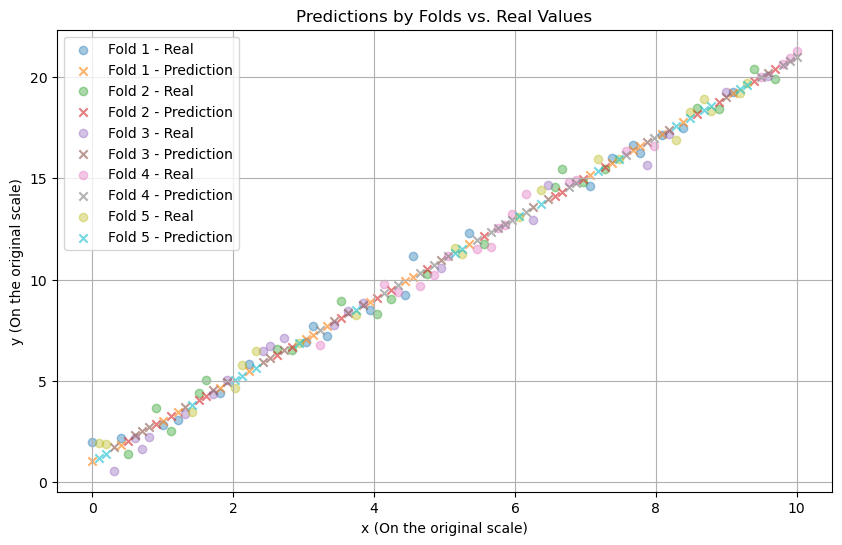

In [14]:
# Representation:Predictions by Folds vs. Real Values
plt.figure(figsize=(10, 6))
plt.title("Predictions by Folds vs. Real Values")
plt.xlabel("x (On the original scale)")
plt.ylabel("y (On the original scale)")

for i in range(len(x_test_all)):
    plt.scatter(x_test_all[i], y_test_true_all[i], label=f'Fold {i+1} - Real', alpha=0.4, marker='o')
    plt.scatter(x_test_all[i], y_test_pred_all[i], label=f'Fold {i+1} - Prediction', alpha=0.6, marker='x')

plt.legend()
plt.grid(True)
plt.show()


# These differences are the error ***(loss)*** that ***MSELoss*** also calculated at the end of each fold. 
# The fact that most of the predictions are close to the real values shows that: 
- ## The model works well, The learning was successful. 
- ## If the variance were very large, it would indicate that the model is unstable or weak.

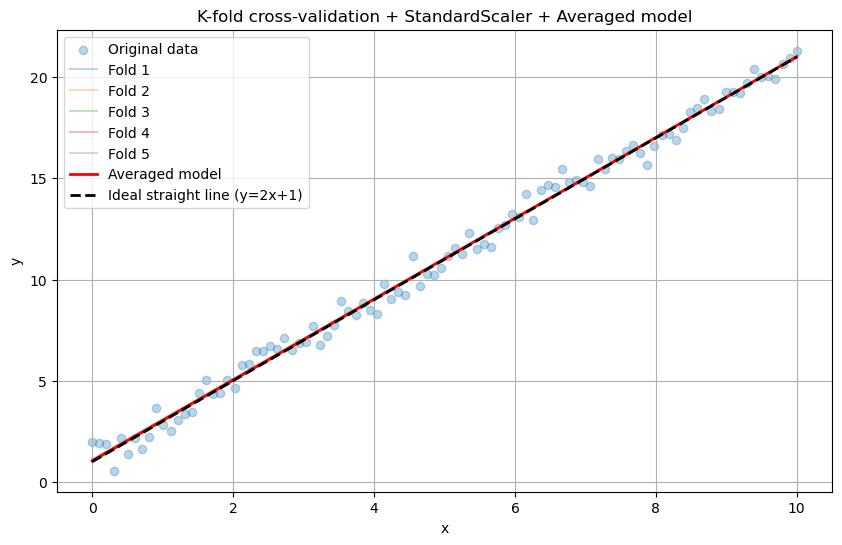

In [15]:
# Representation: Original data and the straight line of each fold + averaged model
x_plot = torch.linspace(0, 10, 100).unsqueeze(1) # The same original data again
plt.figure(figsize=(10, 6))
plt.scatter(x.numpy(), y.numpy(), label='Original data', alpha=0.3)

# Representation of each straight line learned by the fold
for i in range(len(weights)):
    y_fold = weights[i] * x_plot + biases[i]
    '''This means that during each fold: 
        - You have learned a straight line in the form y = w*x + b, 
        - Then you scaled it back to the original data scale, 
        - And you drew these lines based on a smooth, continuous x_plot.
    '''
    plt.plot(x_plot.numpy(), y_fold.numpy(), alpha=0.3, label=f'Fold {i+1}')

# Plotting a Line of an Averaged Model
y_avg = avg_w * x_plot + avg_b
plt.plot(x_plot.numpy(), y_avg.numpy(), color='red', linewidth=2, label='Averaged model')
    
# The ideal (noiseless) straight line should also be visible
y_ideal = 2 * x_plot + 1
plt.plot(x_plot.numpy(), y_ideal.numpy(), color='black', linestyle='--', linewidth=2, label='Ideal straight line (y=2x+1)')
    
plt.title("K-fold cross-validation + StandardScaler + Averaged model")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()


- ## Each fold uses its own StandardScaler.
- ## The weights of the models at the end of the fold are scaled back to the original scale (w_orig, b_orig).
- ## These scaled back values are added to the figure (weights, biases).
- ## The x_plot is also on the original scale → there is complete harmony.

# In each fold, you see a slightly different set of data. Therefore, each fold model learns a slightly different weight and bias → because it sees different patterns. You then average the weights to get an averaged model → this will be the model that describes the overall trend represented by the entire data set.

# ***We made predictions with different data to find a linear conclusion***

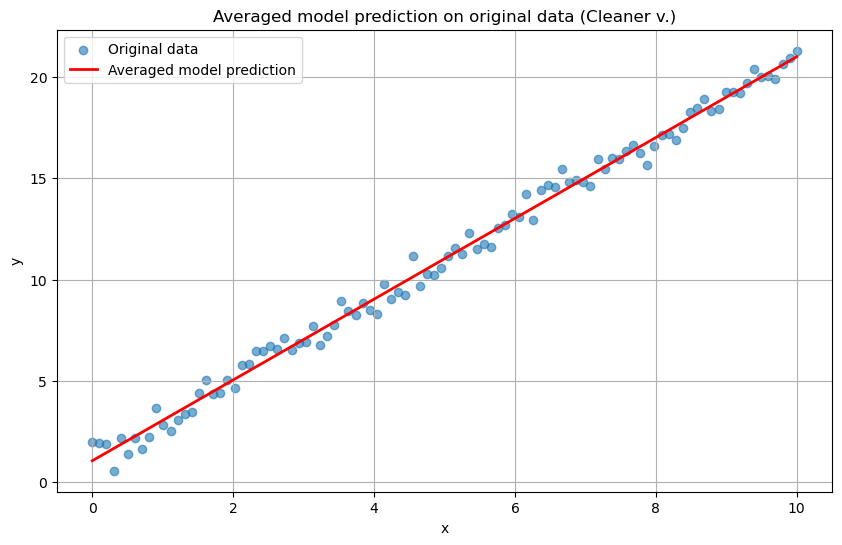

In [16]:
x_plot = torch.linspace(0, 10, 100).unsqueeze(1)  # The same original data again
y_avg = avg_w * x_plot + avg_b

# Representation:
plt.figure(figsize=(10, 6))
plt.scatter(x.numpy(), y.numpy(), label='Original data', alpha=0.6)
plt.plot(x_plot.numpy(), y_avg.numpy(), color='red', label='Averaged model prediction', linewidth=2)
plt.title("Averaged model prediction on original data (Cleaner v.)")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()


- # ***Learning:*** recognizing patterns in the learning data. 
- # ***Prediction:*** the application of a learned pattern to unknown data. 
- # ***KFold:*** multiple slicing → more reliable results → averaged model.